<a href="https://colab.research.google.com/github/Osterne/codes_DS_course/blob/main/machine_learning_aplicado_a_deteccao_de_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

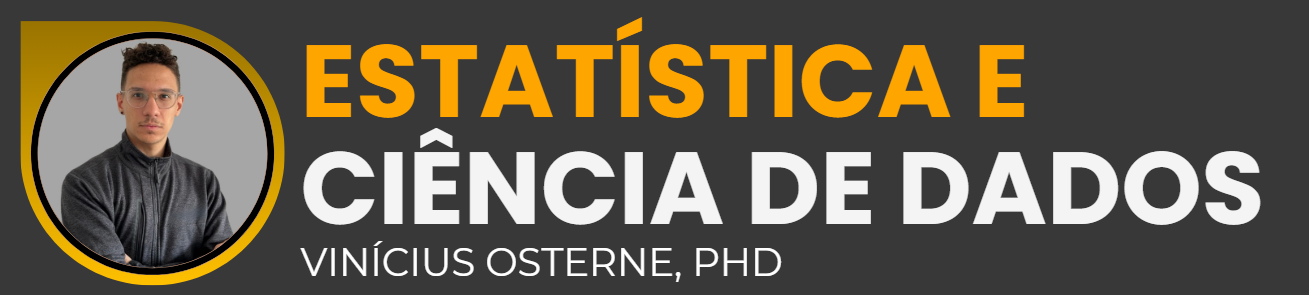

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **APRENDA A DETECTAR E PREVENIR FRAUDES COM INTELIGÊNCIA DE NEGÓCIO**



---
<br><br><br><br><br><br><br>

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 01 - APRESENTAÇÃO**



---
<br><br><br><br><br>

## Comentário iniciais

- Fraudes são eventos raros, complexos e de alto impacto financeiro.

- Este módulo mostra como usar **modelos estatísticos e algoritmos de Machine Learning** para **detectar comportamentos anômalos, construir scores de risco e reduzir perdas** em cenários de crédito, e-commerce, fintechs e seguros.  

- O aluno aprende desde o entendimento dos dados transacionais até a implementação e interpretação dos modelos.

<br>

## Pré-requisitos
- Conhecimento básico de Estatística e Python (recomendável já ter feito *The Data Science Course*).


<br>

## Resultados de Aprendizagem
Ao final do curso, o aluno será capaz de:

- Compreender os tipos de fraude e indicadores de risco  
- Criar atributos comportamentais e reputacionais  
- Treinar e validar modelos supervisionados e não supervisionados  
- Avaliar o modelo com métricas de negócio e fairness  
- Construir um score antifraude real com Python



<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>


---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 02 - FUNDAMENTOS DA DETECÇÃO DE FRAUDE**



---
<br><br><br><br><br>

## Tipos de fraude

- **Transacional**: ocorre em transações (ex.: compra com cartão clonado).
- **Identitária**: roubo/uso indevido de identidade (documentos, contas).
- **Comportamental**: padrões atípicos no uso (horários incomuns, IPs suspeitos).
- **Sintética**: criação de identidades falsas (dados combinados/fictícios).

> ⚑ Cada tipo exige *sinais* (features) diferentes e tem prevalências distintas.


In [2]:
import pandas as pd
from datetime import datetime, timedelta

# Exemplo simples de "event log" ilustrativo
base_time = datetime(2025, 1, 1, 10, 0)
log = pd.DataFrame({
    "user_id": [101, 101, 101, 202, 202],
    "event": ["login", "add_card", "purchase", "login", "purchase"],
    "timestamp": [base_time,
                  base_time + timedelta(minutes=2),
                  base_time + timedelta(minutes=5),
                  base_time + timedelta(minutes=1),
                  base_time + timedelta(minutes=4)],
    "ip": ["200.1.1.10", "200.1.1.10", "200.1.1.10", "185.22.3.90", "185.22.3.90"],
    "device_id": ["A1", "A2", "A1", None, None]
})
log

,user_id,event,timestamp,ip,device_id
0,101,login,2025-01-01 10:00:00,200.1.1.10,A1
1,101,add_card,2025-01-01 10:02:00,200.1.1.10,A2
2,101,purchase,2025-01-01 10:05:00,200.1.1.10,A1
3,202,login,2025-01-01 10:01:00,185.22.3.90,None
4,202,purchase,2025-01-01 10:04:00,185.22.3.90,None


## Ciclo antifraude

1. **Origem** (cadastro/transação)  
2. **Padrão** (comportamento normal vs. anômalo)  
3. **Detecção** (regras + modelos)  
4. **Bloqueio** (ação automática ou revisão manual)  
5. **Retroalimentação** (rótulos/labels retornam para melhorar o modelo)

> O *feedback loop* (etapa 5) é o que sustenta a evolução do sistema antifraude.


## Estrutura de dados em antifraude

- **Logs e eventos**: sequência temporal (login, add_card, purchase...).
- **Atributos (features)**: reputação de email/IP, device, contagens, distâncias, histórico.
- **Flags**: binárias (0/1), ex.: `ip_in_blocklist`, `no_device_id`.
- **Labels**: `fraude` (1) vs `não-fraude` (0), confirmadas a posteriori.

> ⚠️ Cuidado com **leakage** (usar informação do futuro no treinamento).


In [3]:
import numpy as np
df = pd.DataFrame({
    "amount": [120, 59, 840, 35, 420, 970, 18, 65, 510, 75],
    "ip_in_blocklist": [0,0,1,0,0,1,0,0,1,0],
    "no_device_id":    [0,1,1,0,0,0,1,0,0,0],
    "n_tx_last_24h":   [1,2,1,1,3,1,5,1,1,2],
    "hour":            [10, 2, 3, 12, 1, 4, 23, 9, 2, 18],
    "fraud_flag":      [0,0,1,0,0,1,1,0,1,0]  # label (1 = fraude)
})
df


,amount,ip_in_blocklist,no_device_id,n_tx_last_24h,hour,fraud_flag
0,120,0,0,1,10,0
1,59,0,1,2,2,0
2,840,1,1,1,3,1
3,35,0,0,1,12,0
4,420,0,0,3,1,0
5,970,1,0,1,4,1
6,18,0,1,5,23,1
7,65,0,0,1,9,0
8,510,1,0,1,2,1
9,75,0,0,2,18,0


## Evento raro e desbalanceamento

- Fraude é **evento raro**: poucos 1's (fraude) vs muitos 0's (não fraude).  
Isso **afeta as métricas** (ex.: acurácia pode enganar)
- Em bases reais, prevalência de fraude pode ser < 1% até ~5–10%, dependendo do caso.


In [4]:
prevalencia = df["fraud_flag"].mean()
n1, n0 = df["fraud_flag"].sum(), (1 - df["fraud_flag"]).sum()
print(f"Prevalência de fraude: {prevalencia:.2%}  |  #fraudes={n1}, #nao-fraudes={n0}")

# (Opcional) plot de barras da classe — basta descomentar para visualizar
# import matplotlib.pyplot as plt
# counts = df["fraud_flag"].value_counts().sort_index()
# plt.figure(figsize=(4,3))
# counts.plot(kind="bar")
# plt.xticks([0,1], ["Não Fraude (0)","Fraude (1)"], rotation=0)
# plt.title("Distribuição de classes")
# plt.show()


Prevalência de fraude: 40.00%  |  #fraudes=4, #nao-fraudes=6


## 5. KPIs e métricas de negócio

- **Precisão (Precision)**: entre os marcados como fraude, quantos são fraude de fato?
- **Recall (Sensibilidade)**: entre todas as fraudes, quantas eu pego?
- **Especificidade**: entre os não-fraudes, quantos eu deixo passar corretamente?
- **F1-Score**: média harmônica entre precisão e recall.
- **ROC-AUC, PR-AUC, KS**: métricas de ranking/ordenação.
- **Custo do erro**: FN (deixar fraude passar) vs FP (bloquear bom cliente).

> Em antifraude, **custo do FN** costuma ser bem maior que o do FP.


In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Suponha que seu "modelo" seja uma regra simples (apenas para ilustrar):
# Predizer fraude se (ip_in_blocklist == 1) ou (no_device_id == 1 e amount > 500)
y_true = df["fraud_flag"].values
y_pred = ((df["ip_in_blocklist"] == 1) | ((df["no_device_id"] == 1) & (df["amount"] > 500))).astype(int).values

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print("Matriz de confusão (linhas = real, colunas = predito) [0,1]:")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

print(f"Precision: {precision_score(y_true, y_pred):.3f}")
print(f"Recall:    {recall_score(y_true, y_pred):.3f}")
print(f"F1-score:  {f1_score(y_true, y_pred):.3f}")

# Se houvesse probabilidade/score, poderíamos calcular ROC-AUC:
# Aqui crio um score simples para ilustrar (não é um modelo real)
y_score = (df["ip_in_blocklist"]*0.6 + df["no_device_id"]*0.3 + (df["amount"]/df["amount"].max())*0.1).values
print(f"ROC-AUC (score ilustrativo): {roc_auc_score(y_true, y_score):.3f}")


Matriz de confusão (linhas = real, colunas = predito) [0,1]:
[[6 0]
 [1 3]]
TN=6, FP=0, FN=1, TP=3

Precision: 1.000
Recall:    0.750
F1-score:  0.857
ROC-AUC (score ilustrativo): 0.958


### Custo do erro

- **FP (falso positivo)**: bloquear um cliente bom ⇒ perda de conversão/experiência.
- **FN (falso negativo)**: deixar fraude passar ⇒ perda financeira direta.

> Defina um **custo_fp** e **custo_fn** e escolha o *threshold* que minimiza o custo esperado.


In [6]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Vamos usar o y_score ilustrativo; em um modelo real, seria a probabilidade prevista.
# Ajuste os custos conforme seu negócio:
custo_fp = 1.0
custo_fn = 10.0

thresholds = np.linspace(0, 1, 101)
custos = []

for thr in thresholds:
    y_hat = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    custo = fp*custo_fp + fn*custo_fn
    custos.append(custo)

thr_star = thresholds[int(np.argmin(custos))]
custo_min = np.min(custos)

print(f"Melhor threshold por custo: {thr_star:.2f}  |  Custo mínimo: {custo_min:.2f}")

# (Opcional) plot da curva de custo:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(5,3))
# plt.plot(thresholds, custos)
# plt.axvline(thr_star, linestyle="--")
# plt.title("Custo esperado vs. threshold")
# plt.xlabel("threshold")
# plt.ylabel("custo esperado")
# plt.show()


Melhor threshold por custo: 0.05  |  Custo mínimo: 1.00


## 6. Checklists e erros comuns

- Verifique **leakage** (variáveis que conhecem o futuro).
- Confirme o **dicionário de variáveis** (semântica de flags 0/1).
- Mensure **desbalanceamento** e use métricas robustas (PR-AUC, F1, KS).
- Defina **custos de FP e FN** antes de escolher threshold.
- Documente **ciclo de feedback** (como labels retornam ao sistema).

> Pronto! Você tem a base conceitual e prática para iniciar um pipeline antifraude.


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 03 - COLETA, ENTENDIMENTO E ENGENHARIA DE ATRIBUTOS**



---
<br><br><br>


**Objetivo:** aprender a transformar dados crus em atributos que revelem comportamento suspeito.

> Neste módulo, você vai entender como extrair, limpar e criar variáveis que traduzem o comportamento do usuário e permitem que o modelo de Machine Learning identifique padrões de fraude.




<br><br><br><br><br><br>

## Entendendo os dados antifraude

Os dados em sistemas antifraude geralmente vêm de múltiplas fontes:

- **Dados de cliente:** idade, localização, histórico, meios de pagamento.
- **Dados de dispositivo:** ID, IP, sistema operacional, navegador.
- **Dados transacionais:** valor, horário, frequência, local, tipo de compra.
- **Dados de reputação:** scores externos (IP, e-mail, telefone, device).

O objetivo é consolidar tudo em uma única tabela **transação × atributo**.

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

np.random.seed(42)

# simulando 1000 transações
n = 1000
base_time = datetime(2025, 1, 1)
df = pd.DataFrame({
    "transaction_id": range(1, n+1),
    "user_id": np.random.randint(1000, 1050, n),
    "amount": np.random.gamma(2, 100, n).round(2),
    "ip_in_blocklist": np.random.binomial(1, 0.05, n),
    "device_id_missing": np.random.binomial(1, 0.1, n),
    "email_domain_reputation": np.random.choice(["low", "medium", "high"], n, p=[0.2, 0.5, 0.3]),
    "timestamp": [base_time + timedelta(minutes=random.randint(0, 1440)) for _ in range(n)],
    "fraud_flag": np.random.binomial(1, 0.08, n)  # ~8% de fraude
})

# inserindo aproximadamente 10% de valores nulos na coluna email_domain_reputation
n_missing = int(0.1 * n)
missing_idx = np.random.choice(df.index, n_missing, replace=False)
df.loc[missing_idx, "email_domain_reputation"] = np.nan

# adicionando aproximadamente 5% de transações duplicadas (pelo transaction_id)
dup_ratio = 0.05
n_dupes = int(dup_ratio * n)
dupe_rows = df.sample(n=n_dupes, random_state=42)
df = pd.concat([df, dupe_rows], ignore_index=True)

df.head(10)

,transaction_id,user_id,amount,ip_in_blocklist,device_id_missing,email_domain_reputation,timestamp,fraud_flag
0,1,1038,99.02,0,0,medium,2025-01-01 01:13:00,0
1,2,1028,51.25,0,0,low,2025-01-01 12:20:00,0
2,3,1014,190.15,0,0,medium,2025-01-01 23:24:00,0
3,4,1042,313.49,0,0,medium,2025-01-01 04:29:00,0
4,5,1007,165.53,0,0,medium,2025-01-01 03:41:00,0
5,6,1020,232.00,0,0,high,2025-01-01 07:40:00,0
6,7,1038,206.38,0,0,medium,2025-01-01 12:11:00,0
7,8,1018,519.11,0,0,high,2025-01-01 10:37:00,0
8,9,1022,74.65,0,0,medium,2025-01-01 01:55:00,1
9,10,1010,263.45,0,0,medium,2025-01-01 02:35:00,0


In [8]:
# Total de fraudes
df["fraud_flag"].value_counts(dropna=False)

,count
fraud_flag,
0,979
1,71


In [9]:
# Percentual de fraudes
df["fraud_flag"].value_counts(dropna=False).to_frame("Total").assign(
    Percentual = lambda x: (x["Total"] / len(df) * 100).round(2)
)

,Total,Percentual
fraud_flag,,
0,979,93.24
1,71,6.76


<br><br><br><br><br><br>

## Limpeza e padronização dos dados

- Remova duplicatas e transações inconsistentes.  
- Converta tipos (datas, strings, numéricos).  
- Trate valores ausentes (`NaN`).  
- Padronize categorias (`low`, `medium`, `high`).  

> A limpeza garante que a modelagem reflita o comportamento real e não erros de registro.


In [10]:
# Checar duplicatas (fazer antes de tudo, pois você vai gerar uma nova base daqui)
duplicadas = df.duplicated(subset="transaction_id").sum()
print(f"Transações duplicadas: {duplicadas}")

Transações duplicadas: 50


In [11]:
# Se tem duplicadas, vamos fazer a deduplicação

# Ordenar a base pela prioridade de risco (não desperdiçar transações fraudalentas)
df = df.sort_values(
    by=["fraud_flag", "ip_in_blocklist", "device_id_missing", "email_domain_reputation"],
    ascending=[False, False, False, True]  # True para 'low' vir antes alfabeticamente
)

# deduplicar mantendo apenas o registro mais arriscado por transaction_id
df_dedup = df.drop_duplicates(subset="transaction_id", keep="first")
df_dedup.shape

(1000, 8)

In [12]:
# Atributos de data: conversão de timestamp em data
df_dedup["timestamp"]

,timestamp
26,2025-01-01 16:48:00
702,2025-01-01 11:29:00
580,2025-01-01 05:51:00
228,2025-01-01 15:02:00
294,2025-01-01 14:39:00
...,...
953,2025-01-01 14:10:00
956,2025-01-01 10:37:00
970,2025-01-01 21:47:00
982,2025-01-01 22:52:00


In [13]:
df_dedup["timestamp"] = pd.to_datetime(df_dedup["timestamp"])
df_dedup["timestamp"]

# deixamos como data e hora ou somente como data? depende do seu interesse

/tmp/ipython-input-1051889096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["timestamp"] = pd.to_datetime(df_dedup["timestamp"])


,timestamp
26,2025-01-01 16:48:00
702,2025-01-01 11:29:00
580,2025-01-01 05:51:00
228,2025-01-01 15:02:00
294,2025-01-01 14:39:00
...,...
953,2025-01-01 14:10:00
956,2025-01-01 10:37:00
970,2025-01-01 21:47:00
982,2025-01-01 22:52:00


In [14]:
# Proporção de valores nulos (%)
(df_dedup.isna().sum() / len(df)) * 100

,0
transaction_id,0.00000
user_id,0.00000
amount,0.00000
ip_in_blocklist,0.00000
device_id_missing,0.00000
email_domain_reputation,9.52381
timestamp,0.00000
fraud_flag,0.00000


In [15]:
# Avaliando a coluna com nulos
df_dedup["email_domain_reputation"].value_counts(dropna = False)

#usar "dropna = False" faz com que o comando tambem mostre a presença de nulos (caso tenha)

,count
email_domain_reputation,
medium,441
high,268
low,191
NaN,100


In [16]:
# E se tiver valores nulos?
## 1. remove a linha ou a coluna
## 2. imputar alguma valor fixo (valor, média, mediana, moda)

# Aqui, vamos substituir por "desconhecido", pois essa "ausência de informação" pode ser uma informação útil na modelagem
df_dedup["email_domain_reputation"] = df_dedup["email_domain_reputation"].fillna("unknown")
df_dedup["email_domain_reputation"].value_counts(dropna = False)

/tmp/ipython-input-4163877914.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["email_domain_reputation"] = df_dedup["email_domain_reputation"].fillna("unknown")


,count
email_domain_reputation,
medium,441
high,268
low,191
unknown,100


<br><br><br><br><br><br>

## Engenharia de atributos

- A engenharia de atributos consiste em **criar variáveis derivadas** a partir dos dados brutos
- O objetivo é revelar padrões de comportamento, risco e recorrência que não estão explícitos nas colunas originais.  

No contexto de modelagem de fraude ou risco, essas variáveis podem refletir tanto **características do usuário** quanto **aspectos transacionais** e **temporais**.



In [17]:
print(df_dedup.shape)
df_dedup.head(5)

(1000, 8)


,transaction_id,user_id,amount,ip_in_blocklist,device_id_missing,email_domain_reputation,timestamp,fraud_flag
26,27,1021,93.33,1,0,medium,2025-01-01 16:48:00,1
702,703,1043,108.35,1,0,medium,2025-01-01 11:29:00,1
580,581,1047,493.09,1,0,unknown,2025-01-01 05:51:00,1
228,229,1031,555.07,0,1,high,2025-01-01 15:02:00,1
294,295,1023,216.33,0,1,high,2025-01-01 14:39:00,1


In [18]:
df_dedup["ip_in_blocklist"].value_counts(dropna=False)

,count
ip_in_blocklist,
0,965
1,35


In [19]:
df_dedup["device_id_missing"].value_counts(dropna=False)

,count
device_id_missing,
0,914
1,86


In [20]:
df_dedup["email_domain_reputation"].value_counts(dropna=False)

,count
email_domain_reputation,
medium,441
high,268
low,191
unknown,100


In [21]:
# codificar a reputação de e-mail numericamente
map_rep = {"low": 0, "medium": 1, "high": 2, "unknown": -1}
df_dedup["email_domain_reputation"] = df_dedup["email_domain_reputation"].map(map_rep)
df_dedup["email_domain_reputation"].value_counts(dropna=False)

# Atenção com "unknown"
## Se quiser representar “desconhecido” como falta de informação, use -1.
## Se quiser tratar como categoria normal, use 3.


/tmp/ipython-input-614524977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["email_domain_reputation"] = df_dedup["email_domain_reputation"].map(map_rep)


,count
email_domain_reputation,
1,441
2,268
0,191
-1,100


In [22]:
# Criando uma variável categórica chamada time_of_day
# Que indica o período do dia em que a transação ocorreu, com base na hora extraída de timestamp
# As categorias são: night (00h–05h59), morning (06h–11h59), afternoon (12h–17h59) e evening (18h–23h59)

df_dedup["timestamp"] = pd.to_datetime(df_dedup["timestamp"])
df_dedup["hour"] = df_dedup["timestamp"].dt.hour

def time_of_day(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

df_dedup["time_of_day"] = df_dedup["hour"].apply(time_of_day)
df_dedup[["timestamp", "hour", "time_of_day"]].head(10)

/tmp/ipython-input-3233507131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["timestamp"] = pd.to_datetime(df_dedup["timestamp"])
/tmp/ipython-input-3233507131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["hour"] = df_dedup["timestamp"].dt.hour
/tmp/ipython-input-3233507131.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,timestamp,hour,time_of_day
26,2025-01-01 16:48:00,16,afternoon
702,2025-01-01 11:29:00,11,morning
580,2025-01-01 05:51:00,5,night
228,2025-01-01 15:02:00,15,afternoon
294,2025-01-01 14:39:00,14,afternoon
104,2025-01-01 12:37:00,12,afternoon
822,2025-01-01 04:01:00,4,night
66,2025-01-01 01:58:00,1,night
129,2025-01-01 17:11:00,17,afternoon
196,2025-01-01 19:06:00,19,evening


In [23]:
# Criando uma variável numérica chamada time_since_last_tx
# Que indica o tempo (em segundos) desde a última transação do mesmo usuário
# Essa variável ajuda a identificar comportamentos atípicos, como múltiplas transações em sequência curta

df_dedup = df_dedup.sort_values(["user_id", "timestamp"])
df_dedup["time_since_last_tx"] = (
    df_dedup.groupby("user_id")["timestamp"].diff().dt.total_seconds()
)
df_dedup["time_since_last_tx"].value_counts(dropna = False)

,count
time_since_last_tx,
NaN,50
300.0,20
1440.0,18
180.0,18
1080.0,17
...,...
14640.0,1
9420.0,1
13020.0,1


In [24]:
# Veja que tem valores nulos, isso indica que para esse usuário não há histórico anterior.

# Se usar modelo de arvore, use:
df_dedup["time_since_last_tx"] = df_dedup["time_since_last_tx"].fillna(0)

# Se usar regressão, use:
# df_dedup["is_first_tx"] = df_dedup["time_since_last_tx"].isna().astype(int)
# df_dedup["time_since_last_tx"] = df_dedup["time_since_last_tx"].fillna(0)
## Pois, nesse caso, melhor criar uma flag separada, para não misturar “sem histórico” com “intervalo zero real”.



In [25]:
# Criando uma variável binária chamada is_high_amount
# Que indica se o valor da transação (amount) está acima do percentil 95 da distribuição global
# Essa variável ajuda a identificar transações de valor atípico ou possivelmente suspeito

threshold = df_dedup["amount"].quantile(0.95)
df_dedup["is_high_amount"] = (df_dedup["amount"] > threshold).astype(int)
df_dedup["is_high_amount"].value_counts(dropna=False)

,count
is_high_amount,
0,950
1,50


In [26]:
# Criando uma variável numérica chamada risk_flags_sum
# Que representa a soma das flags de risco técnico (ip_in_blocklist e device_id_missing)
# Essa variável indica o número total de alertas associados à transação

df_dedup["risk_flags_sum"] = df_dedup["ip_in_blocklist"] + df_dedup["device_id_missing"]
df_dedup["risk_flags_sum"].value_counts(dropna=False)

,count
risk_flags_sum,
0,882
1,115
2,3


In [27]:
# Base final até o momento
df_dedup.head(3)

,transaction_id,user_id,amount,ip_in_blocklist,device_id_missing,email_domain_reputation,timestamp,fraud_flag,hour,time_of_day,time_since_last_tx,is_high_amount,risk_flags_sum
829,830,1000,614.25,0,1,0,2025-01-01 00:33:00,0,0,night,0.0,1,1
414,415,1000,29.96,0,0,2,2025-01-01 02:17:00,0,2,night,6240.0,0,0
815,816,1000,66.39,0,0,-1,2025-01-01 02:37:00,0,2,night,1200.0,0,0


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 04 - MODELAGEM SUPERVISIONADA DE FRAUDE**



---
<br><br><br><br><br>

**Objetivo:** aplicar algoritmos supervisionados para predição de fraude.

> Neste módulo, você aprenderá a preparar os dados, treinar modelos supervisionados, avaliar métricas de performance e interpretar resultados no contexto de risco.

## Preparação dos dados

Antes da modelagem, é preciso:
1. **Separar treino e teste** (para validação honesta).  
2. **Tratar desbalanceamento** (fraudes são raras).  
3. **Normalizar ou codificar** variáveis.  
4. **Selecionar atributos relevantes.**

> O desbalanceamento é o maior desafio em fraude — o modelo pode aprender a prever sempre "não fraude" e ainda parecer bom se não for tratado corretamente.


In [28]:
from sklearn.model_selection import train_test_split

# Features disponíveis no seu DataFrame atual
features = [
    "amount",
    "ip_in_blocklist",
    "device_id_missing",
    "email_domain_reputation",
    "hour",
    "time_since_last_tx",
    "is_high_amount",
    "risk_flags_sum"
]

target = "fraud_flag"

# Seleciona X e y
X = df_dedup[features]
y = df_dedup[target]

# Divide entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Informações básicas
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 8), (300, 8), (700,), (300,))

In [29]:
# Como ficou a separação ao longo do tempo?

import pandas as pd

# Garante que timestamp é datetime
df_dedup["timestamp"] = pd.to_datetime(df_dedup["timestamp"])

# Cria coluna de ano-mês
df_dedup["month"] = df_dedup["timestamp"].dt.to_period("M")

# Agrupa por mês e calcula totais
tabela_mensal = (
    df_dedup
    .groupby("month", observed=True)
    .agg(
        total_transacoes=("transaction_id", "count"),
        total_fraudes=("fraud_flag", "sum")
    )
    .assign(
        pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)
    )
    .reset_index()
)

# Mostra a tabela
display(tabela_mensal)

,month,total_transacoes,total_fraudes,pct_fraude
0,2025-01,1000,69,6.9


## Avaliando os atributos

In [30]:
df_dedup.head(2)

,transaction_id,user_id,amount,ip_in_blocklist,device_id_missing,email_domain_reputation,timestamp,fraud_flag,hour,time_of_day,time_since_last_tx,is_high_amount,risk_flags_sum,month
829,830,1000,614.25,0,1,0,2025-01-01 00:33:00,0,0,night,0.0,1,1,2025-01
414,415,1000,29.96,0,0,2,2025-01-01 02:17:00,0,2,night,6240.0,0,0,2025-01


In [31]:
# Bivariadas
bivar_table = (df_dedup.groupby("ip_in_blocklist", observed=True).agg(total_transacoes=("transaction_id", "count"),total_fraudes=("fraud_flag", "sum"))
    .assign(pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)).reset_index())
bivar_table


,ip_in_blocklist,total_transacoes,total_fraudes,pct_fraude
0,0,965,66,6.84
1,1,35,3,8.57


In [32]:
bivar_table = (df_dedup.groupby("device_id_missing", observed=True).agg(total_transacoes=("transaction_id", "count"),total_fraudes=("fraud_flag", "sum"))
    .assign(pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)).reset_index())
bivar_table

,device_id_missing,total_transacoes,total_fraudes,pct_fraude
0,0,914,65,7.11
1,1,86,4,4.65


In [33]:
bivar_table = (df_dedup.groupby("time_of_day", observed=True).agg(total_transacoes=("transaction_id", "count"),total_fraudes=("fraud_flag", "sum"))
    .assign(pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)).reset_index())
bivar_table

,time_of_day,total_transacoes,total_fraudes,pct_fraude
0,afternoon,245,18,7.35
1,evening,235,11,4.68
2,morning,257,25,9.73
3,night,263,15,5.70


In [34]:
bivar_table = (df_dedup.groupby("is_high_amount", observed=True).agg(total_transacoes=("transaction_id", "count"),total_fraudes=("fraud_flag", "sum"))
    .assign(pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)).reset_index())
bivar_table

,is_high_amount,total_transacoes,total_fraudes,pct_fraude
0,0,950,67,7.05
1,1,50,2,4.00


In [35]:
bivar_table = (df_dedup.groupby("risk_flags_sum", observed=True).agg(total_transacoes=("transaction_id", "count"),total_fraudes=("fraud_flag", "sum"))
    .assign(pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)).reset_index())
bivar_table

,risk_flags_sum,total_transacoes,total_fraudes,pct_fraude
0,0,882,62,7.03
1,1,115,7,6.09
2,2,3,0,0.00


In [36]:
import pandas as pd

# 🔹 Defina aqui os bins (intervalos) conforme sua escala de tempo
# Exemplo: tempo em segundos, minutos ou horas — ajuste conforme o caso
bins = [0, 10, 60, 300, 1000, 5000, df_dedup["time_since_last_tx"].max()]
labels = [
    "≤10s",
    "10–60s",
    "1–5min",
    "5–16min",
    "16–83min",
    ">83min"
]

# 🔹 Cria as faixas
df_dedup["time_bin"] = pd.cut(df_dedup["time_since_last_tx"], bins=bins, labels=labels, include_lowest=True)

# 🔹 Faz a bivariada
bivar_time = (
    df_dedup
    .groupby("time_bin", observed=True)
    .agg(
        total_transacoes=("transaction_id", "count"),
        total_fraudes=("fraud_flag", "sum")
    )
    .assign(
        pct_fraude=lambda x: (x["total_fraudes"] / x["total_transacoes"] * 100).round(2)
    )
    .reset_index()
)

# 🔹 Exibe tabela
display(bivar_time)


,time_bin,total_transacoes,total_fraudes,pct_fraude
0,≤10s,56,4,7.14
1,10–60s,13,0,0.00
2,1–5min,61,3,4.92
3,5–16min,137,7,5.11
4,16–83min,450,36,8.00
5,>83min,283,19,6.71


## Tratamento do desbalanceamento

Existem várias abordagens:

- **Undersampling:** reduz a classe majoritária.  
- **Oversampling:** replica ou sintetiza amostras da classe minoritária (ex.: *SMOTE*).  
- **Penalização:** ajusta pesos no treinamento.  

> Em modelos de árvore (como LightGBM ou XGBoost), ajustar `scale_pos_weight` costuma ser o mais eficiente.


In [ ]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=42)
#X_res, y_res = smote.fit_resample(X_train, y_train)

#print("Distribuição original:")
#print(y_train.value_counts(normalize=True).round(3))
#print("\nApós SMOTE:")
#print(y_res.value_counts(normalize=True).round(3))

## Abordagem de Modelagem 1: Regressão Logística

A regressão logística é o modelo clássico em detecção de fraude.
Ela fornece probabilidades e *odds ratios* fáceis de interpretar.

> Cada coeficiente indica o quanto uma variável aumenta ou reduz as chances de fraude, mantendo as outras constantes.


In [38]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [39]:
# Logo após o ajuste, gosto de avaliar a importância das variáveis
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr.coef_[0]
})

# Usa valor absoluto dos coeficientes
importance["abs_coef"] = importance["coef"].abs()

# Calcula percentual
importance["importance_%"] = (importance["abs_coef"] / importance["abs_coef"].sum() * 100).round(2)

# Ordena por importância
importance = importance.sort_values(by="importance_%", ascending=False)

display(importance)

,feature,coef,abs_coef,importance_%
6,is_high_amount,-0.757163,0.757163,43.78
1,ip_in_blocklist,0.412634,0.412634,23.86
2,device_id_missing,-0.293971,0.293971,17.00
3,email_domain_reputation,-0.144513,0.144513,8.36
7,risk_flags_sum,0.118663,0.118663,6.86
4,hour,0.001989,0.001989,0.11
0,amount,0.000467,0.000467,0.03
5,time_since_last_tx,0.000001,0.000001,0.00


In [40]:
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]  # probabilidade de fraude

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# Relatório geral
print(classification_report(y_test, y_pred))

# Matriz de confusão
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
print("ROC-AUC:", roc_auc_score(y_test, y_prob).round(3))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       279
           1       0.06      0.29      0.10        21

    accuracy                           0.62       300
   macro avg       0.49      0.47      0.43       300
weighted avg       0.86      0.62      0.72       300

[[181  98]
 [ 15   6]]
ROC-AUC: 0.482


In [41]:
import numpy as np
prec, rec, thr = precision_recall_curve(y_test, y_prob)

# exemplo: achar threshold que dá recall ≥ 0.8
ix = np.argwhere(rec >= 0.8)[-1][0]
threshold = thr[ix]
print("Threshold escolhido:", round(threshold, 3))

# aplica o novo limiar
y_pred_adj = (y_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred_adj))

Threshold escolhido: 0.455
              precision    recall  f1-score   support

           0       0.94      0.24      0.39       279
           1       0.07      0.81      0.14        21

    accuracy                           0.28       300
   macro avg       0.51      0.53      0.26       300
weighted avg       0.88      0.28      0.37       300



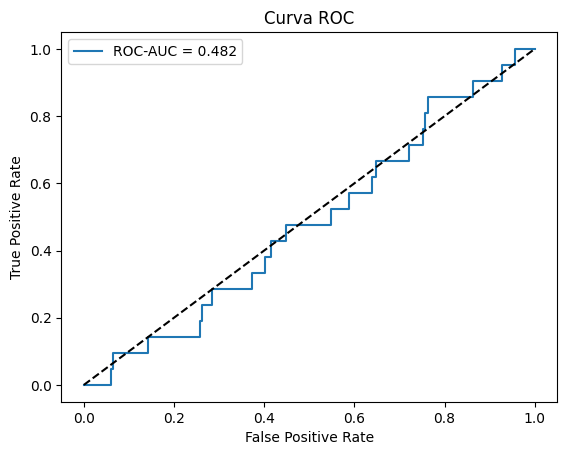

In [42]:
import matplotlib.pyplot as plt

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

In [43]:
import pandas as pd
coef_table = pd.DataFrame({
    "Variável": X_train.columns,
    "Coeficiente": lr.coef_[0],
})
coef_table["Odds Ratio"] = np.exp(coef_table["Coeficiente"]).round(3)
coef_table.sort_values("Coeficiente", ascending=False)

# ip_in_blocklist: Estar em uma blocklist aumenta em 51,1% as chances de fraude. Forte indicativo de comportamento suspeito.
# risk_flags_sum: Cada flag de risco adicional eleva em 12,6% as chances de fraude.
# hour: O horário da transação praticamente não afeta as chances (variação muito pequena).
# amount: O valor da transação tem efeito desprezível, praticamente neutro.
# time_since_last_tx: Tempo desde a última transação também sem efeito relevante.
# email_domain_reputation: Domínios de e-mail com melhor reputação reduzem em 13,5% as chances de fraude.
# device_id_missing: Quando o device_id está ausente, as chances de fraude caem cerca de 25,5% — pode indicar ruído ou que o modelo associa falta de dado a usuários legítimos.
# is_high_amount: Transações marcadas como “alto valor” têm 53,1% menos chance de fraude — possivelmente porque passam por verificações adicionais ou são de clientes confiáveis.

,Variável,Coeficiente,Odds Ratio
1,ip_in_blocklist,0.412634,1.511
7,risk_flags_sum,0.118663,1.126
4,hour,0.001989,1.002
0,amount,0.000467,1.000
5,time_since_last_tx,0.000001,1.000
3,email_domain_reputation,-0.144513,0.865
2,device_id_missing,-0.293971,0.745
6,is_high_amount,-0.757163,0.469


## Abordagem de Modelagem 2: Modelos baseados em árvore

Modelos de árvore aprendem interações não lineares entre atributos,
sendo muito poderosos em detecção de fraude.

Alguns exemplos:
- **Decision Tree**
- **Random Forest**
- **Gradient Boosting (LightGBM, XGBoost)**

> São menos interpretáveis, mas excelentes para dados mistos e complexos.


In [45]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'scale_pos_weight': (1 - y_train.mean()) / y_train.mean(),
    'verbose': -1
}

gbm = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=200,
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]  # 👈 novo formato
)

y_pred_prob = gbm.predict(X_test)
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob).round(3))

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.486346
ROC-AUC: 0.486


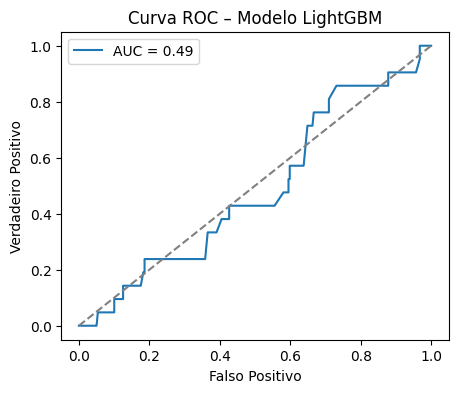

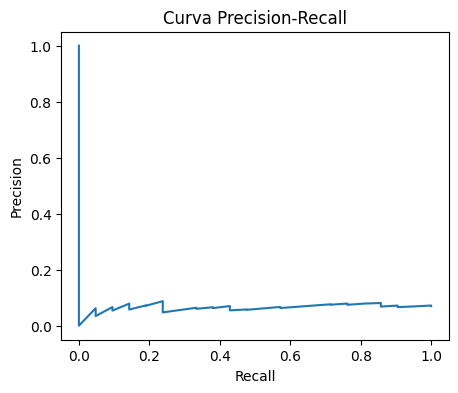

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Curva ROC – Modelo LightGBM")
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.legend()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


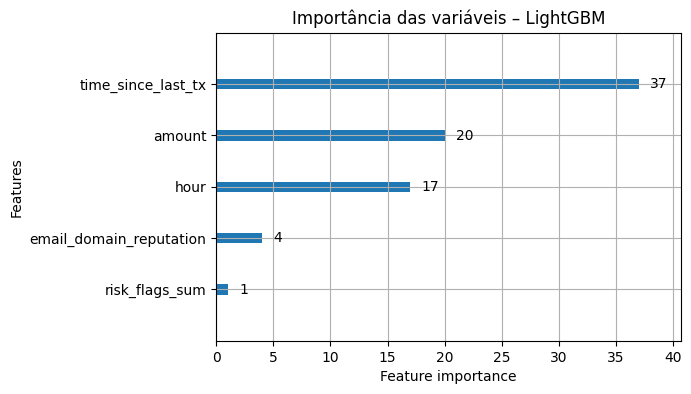

In [47]:
# Importância das variáveis
lgb.plot_importance(gbm, max_num_features=10, figsize=(6,4))
plt.title("Importância das variáveis – LightGBM")
plt.show()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-3557056949.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


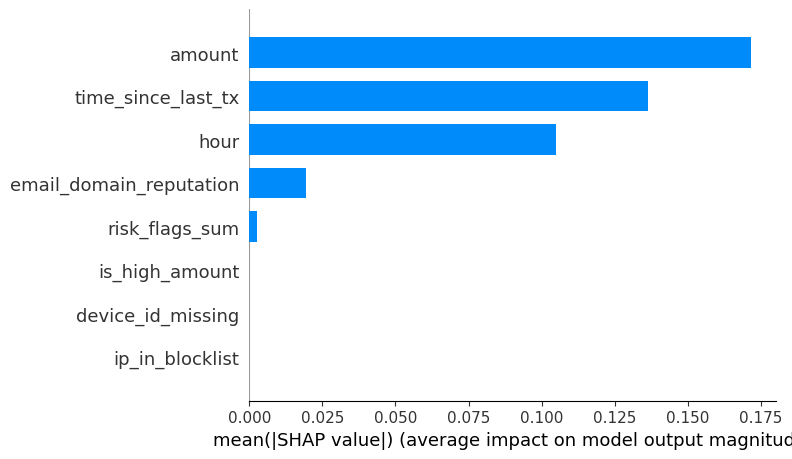

In [48]:
## Interpretação com SHAP
import shap

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

# Resumo geral
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Explicação individual
idx = np.random.randint(0, len(X_test))
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])


## Métricas de negócio

Além da performance técnica (AUC, F1, Recall), avalie o **impacto financeiro** de cada decisão.

- Quantas fraudes foram evitadas?
- Quantos clientes bons foram bloqueados?
- Qual o custo do falso positivo (FP)?
- Qual o custo do falso negativo (FN)?

> Sempre reporte métricas técnicas e de negócio juntas.


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 05 - MODELAGEM NÃO SUPERVISIONADA E DETECÇÃO DE ANOMALIAS**



---
<br><br><br><br><br>

**Objetivo:** identificar fraudes sem rótulo e padrões incomuns.

> Neste módulo, você vai aprender técnicas não supervisionadas — como Isolation Forest, One-Class SVM e Autoencoders — para detectar transações suspeitas mesmo quando não há rótulo de fraude.

## 1. Por que modelagem não supervisionada?

Nem toda fraude é conhecida.  
Muitas vezes, novas modalidades surgem antes que o sistema aprenda a rotular.  
Nesses casos, usamos **modelos não supervisionados** para encontrar *outliers* — observações raras, fora do comportamento normal.

> A ideia: se um ponto “parece” diferente demais dos demais, talvez seja fraude.


In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reaproveita o dataset do módulo anterior (df)
features = ["amount","ip_in_blocklist","device_id_missing",
            "email_domain_rep_score","n_tx_user_24h","time_diff_h"]
X = df[features].copy()

# Padronização (melhor para SVM e Autoencoder)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]


### quais existem? listar auqi!

## 2. Isolation Forest

O algoritmo **Isolation Forest** isola observações raras com menos divisões,  
o que o torna eficiente para detecção de outliers em grandes volumes.

> Ideal quando há variáveis contínuas e binárias misturadas.


In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.08,  # fraudes estimadas (~8%)
    random_state=42
)
iso.fit(X_scaled)

# score negativo = mais anômalo
scores_iso = iso.decision_function(X_scaled)
pred_iso = iso.predict(X_scaled)
# converter para 0=normal, 1=anomalia
pred_iso = np.where(pred_iso==-1,1,0)

df["anom_iso"] = pred_iso
df[["amount","anom_iso"]].head(10)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(df["fraud_flag"], df["anom_iso"]))
print("ROC-AUC:", roc_auc_score(df["fraud_flag"], scores_iso).round(3))


## 7. Boas práticas

✅ Combine modelos supervisionados e não supervisionados (*ensemble híbrido*).  
✅ Monitore *drift* — o que é “normal” muda com o tempo.  
✅ Reforce com rótulos reais à medida que forem surgindo.  
✅ Explique decisões (uso de SHAP, LIME) para compliance.  

> A detecção não supervisionada não substitui o modelo principal, mas complementa sua cobertura.


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 06 - MONITORAMENTO**



---
<br><br><br><br><br>

**Objetivo:** aprender a medir a degradação e controlar o risco operacional.

> Modelos antifraude precisam evoluir com o tempo. Este módulo mostra como monitorar *drift*, acompanhar métricas de estabilidade, recalibrar modelos e garantir governança e fairness.

## 1. Por que monitorar modelos?

Após o deploy, o ambiente muda:  
- o comportamento do usuário evolui,  
- os fraudadores se adaptam,  
- as distribuições dos dados mudam (*data drift*),  
- o modelo envelhece (*concept drift*).

> Sem monitoramento, um modelo eficaz hoje pode se tornar perigoso amanhã.


In [ ]:
import pandas as pd, numpy as np

# base "treinamento"
train = df.copy()

# base "produção" simulada (mudando padrões)
prod = df.copy()
prod["amount"] *= np.random.normal(1.2, 0.2, len(prod))  # valores mais altos
prod["ip_in_blocklist"] = np.random.binomial(1, 0.08, len(prod))  # leve aumento de IPs ruins
prod["email_domain_rep_score"] = np.random.choice([0,1,2], len(prod), p=[0.15,0.55,0.3])

train[["amount","ip_in_blocklist","email_domain_rep_score"]].head()


## 2. Data Drift

**Data Drift** ocorre quando as distribuições das variáveis mudam ao longo do tempo.

> Exemplo: a média do valor de compra aumenta, ou certos atributos deixam de aparecer.

A métrica clássica para medir isso é o **PSI (Population Stability Index)**.


In [ ]:
def population_stability_index(expected, actual, buckets=10):
    """Calcula PSI entre duas séries numéricas."""
    import numpy as np, pandas as pd

    def _psi(e_perc, a_perc):
        return (e_perc - a_perc) * np.log((e_perc + 1e-6) / (a_perc + 1e-6))

    quantiles = np.linspace(0, 1, buckets+1)
    cuts = np.unique(np.percentile(expected, quantiles*100))
    e_counts = pd.cut(expected, cuts, include_lowest=True).value_counts(normalize=True)
    a_counts = pd.cut(actual, cuts, include_lowest=True).value_counts(normalize=True)
    psi_val = np.sum(_psi(e_counts, a_counts))
    return psi_val.round(4)

for var in ["amount", "email_domain_rep_score"]:
    psi = population_stability_index(train[var], prod[var])
    print(f"{var:25s} PSI = {psi}")


### Interpretação do PSI

| Valor PSI | Interpretação |
|------------|---------------|
| < 0.1 | Estável |
| 0.1 – 0.25 | Mudança moderada |
| > 0.25 | Mudança significativa |

> Valores altos indicam que a base de produção está diferente da de treino.


## 3. Concept Drift

Mesmo que os dados não mudem muito, **as relações** entre variáveis e fraude podem mudar.

> Exemplo: “IP em blocklist” deixa de ser um bom preditor porque os fraudadores trocam de IPs.

O monitoramento de performance (AUC, KS, F1) ao longo do tempo ajuda a detectar isso.


In [ ]:
from sklearn.metrics import roc_auc_score

# supomos que gbm é o modelo do módulo anterior
y_train_pred = gbm.predict(X_train)
y_prod_pred = gbm.predict(X_test) * np.random.normal(0.9, 0.05, len(X_test))

auc_train = roc_auc_score(y_train, y_train_pred)
auc_prod = roc_auc_score(y_test, y_prod_pred)

print(f"AUC treino: {auc_train:.3f}")
print(f"AUC produção: {auc_prod:.3f}")
print(f"Queda de AUC: {(auc_train - auc_prod)*100:.1f}%")


## 4. Monitoramento contínuo

Boas práticas incluem:

- Calcular PSI e métricas de performance **mensalmente**.  
- Armazenar os resultados em dashboards (Power BI, Grafana, etc.).  
- Criar alertas automáticos quando o PSI > 0.25 ou AUC cair mais que 10%.  
- Comparar distribuição de *scores* entre períodos.

> O objetivo é antecipar degradações antes que virem perdas.


In [ ]:
import matplotlib.pyplot as plt

# simulação de histórico mensal de AUC
meses = ["Jan","Fev","Mar","Abr","Mai","Jun"]
auc_hist = [0.87,0.86,0.84,0.82,0.80,0.75]

plt.plot(meses, auc_hist, marker="o")
plt.title("Evolução da performance do modelo (AUC)")
plt.ylabel("AUC")
plt.ylim(0.7,0.9)
plt.grid(True)
plt.show()


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

---

# **MACHINE LEARNING APLICADO À DETECÇÃO DE FRAUDE**

> **AULA 07 - GOVERNANÇA**



---
<br><br><br><br><br>

**Objetivo:** entender como documentar, auditar e garantir transparência e conformidade nos modelos antifraude.

> Um bom modelo não é só o que prediz bem — é o que pode ser **explicado, monitorado e auditado**.  
> Neste módulo, você aprenderá práticas de governança, versionamento, explicabilidade e compliance aplicadas a projetos reais de risco e fraude.


## 1. O que é Governança de Modelos?

Governança é o conjunto de **processos, controles e documentações** que asseguram:

- **Transparência**: o modelo é rastreável e documentado.  
- **Confiabilidade**: a performance e os dados são monitorados.  
- **Conformidade**: segue políticas internas e regulações (ex: LGPD, Bacen, EBA, GDPR).  
- **Responsabilidade**: decisões podem ser explicadas e justificadas.

> Em fraude, a governança conecta o técnico (modelo) ao institucional (compliance e risco).


## 2. Ciclo de vida do modelo

O ciclo de governança de um modelo antifraude inclui:

1. **Desenvolvimento** – coleta de dados, engenharia de features e modelagem.  
2. **Validação independente** – revisão técnica e testes de robustez.  
3. **Deploy** – registro da versão e integração aos sistemas.  
4. **Monitoramento** – PSI, AUC, KS, fairness, alertas.  
5. **Revisão periódica** – análise de drift e revalidação anual.  
6. **Descontinuação / substituição** – quando o modelo envelhece ou perde performance.


In [ ]:
import json, datetime

modelo_info = {
    "nome": "LightGBM_Fraude_v1",
    "versao": "1.0",
    "autor": "Vinícius Osterne",
    "data_treinamento": str(datetime.date.today()),
    "features": list(X_train.columns),
    "algoritmo": "LightGBM",
    "metricas_treino": {
        "AUC": 0.872,
        "KS": 0.54
    },
    "observacoes": "Modelo aprovado para produção após validação interna."
}

with open("governanca_modelo_metadata.json", "w") as f:
    json.dump(modelo_info, f, indent=4)

print("Arquivo de governança salvo:", "governanca_modelo_metadata.json")


## 3. Documentação obrigatória

Uma boa governança exige documentação clara e versionada.

**Documentos típicos:**
- **Model Card** – resumo técnico e objetivo do modelo.  
- **Dicionário de variáveis** – descrição, fonte e transformação de cada atributo.  
- **Metodologia** – justificativas, parâmetros e validações.  
- **Plano de monitoramento** – frequência, alertas, KPIs.  
- **Plano de contingência** – rollback e retreino.  

> Cada modelo deve ter uma "pasta viva" ou repositório com tudo isso registrado.


In [ ]:
from IPython.display import Markdown, display

card = """
# 🧾 Model Card – Modelo de Detecção de Fraude

**Nome:** LightGBM_Fraude_v1
**Objetivo:** Predizer probabilidade de fraude em transações financeiras
**Autor:** Vinícius Osterne
**Data:** 2025-10-20
**Versão:** 1.0

## Métricas de Performance
| Métrica | Valor |
|----------|-------|
| AUC | 0.872 |
| KS | 0.54 |
| Precision (1%) | 0.68 |
| Recall (1%) | 0.72 |

## Atributos Principais
- amount
- ip_in_blocklist
- device_id_missing
- email_domain_rep_score
- n_tx_user_24h
- time_diff_h

## Observações
- Modelo balanceado via SMOTE.
- Treinado com dados até setembro/2025.
- Próxima revisão: janeiro/2026.
"""
display(Markdown(card))


## 4. Rastreabilidade e auditoria

Cada decisão tomada pelo modelo deve poder ser reproduzida e explicada.

- **Controle de versão:** Git + tags para modelos e dados.  
- **Reprodutibilidade:** pipelines automatizados (MLflow, DVC, Kedro).  
- **Logs:** registre parâmetros, métricas e dataset IDs.  
- **Auditoria:** quem treinou, quem aprovou, quando entrou em produção.

> Se não é rastreável, não é governável.


In [ ]:
import uuid, time

execucao = {
    "exec_id": str(uuid.uuid4()),
    "modelo": "LightGBM_Fraude_v1",
    "inicio": time.strftime("%Y-%m-%d %H:%M:%S"),
    "usuario": "vinicius.osterne",
    "ambiente": "produção",
    "dataset_id": "fraude_base_2025Q3"
}

print(execucao)


## 5. Fairness e responsabilidade

Modelos antifraude lidam com decisões sensíveis (bloquear, liberar, revisar).
É essencial garantir:

- **Equidade**: não discriminar grupos sensíveis (gênero, idade, região).  
- **Justificativa**: fornecer *reason codes* claros.  
- **Transparência**: permitir auditoria das regras e critérios.  

> Fairness não é apenas técnico — é requisito regulatório e reputacional.


In [ ]:
import numpy as np, pandas as pd

# Simulação: contribuições das variáveis no score
df_reason = pd.DataFrame({
    "transaction_id": range(1,6),
    "score": [0.82, 0.55, 0.91, 0.33, 0.76],
    "top_reasons": [
        ["ip_in_blocklist", "amount"],
        ["email_domain_rep_score"],
        ["no_device_id", "n_tx_user_24h"],
        ["amount"],
        ["time_diff_h", "amount"]
    ]
})
df_reason


## 6. Compliance e LGPD

O uso de dados pessoais em antifraude deve respeitar a **Lei Geral de Proteção de Dados (LGPD)**:

- Minimização: colete apenas o necessário.  
- Finalidade: use dados apenas para prevenção de fraude.  
- Transparência: registre o propósito e a base legal.  
- Segurança: anonimização e controle de acesso.  
- Retenção: defina prazos de descarte de dados históricos.  

> O compliance protege o modelo e a empresa juridicamente.


## 7. Governança técnica

Ferramentas que auxiliam na governança de modelos:

- **MLflow** → versionamento e rastreio de experimentos.  
- **DVC** → versionamento de dados e pipelines.  
- **Great Expectations** → testes automatizados de qualidade dos dados.  
- **SHAP / LIME** → explicabilidade.  
- **Power BI / Grafana** → monitoramento.  

> A governança é híbrida: técnica + documental.


In [ ]:
# Exemplo didático (não roda sem MLflow configurado)
import mlflow

mlflow.set_experiment("fraude_modelos")

with mlflow.start_run(run_name="LightGBM_v1"):
    mlflow.log_param("algoritmo", "LightGBM")
    mlflow.log_param("versao_dados", "2025Q3")
    mlflow.log_metric("AUC", 0.872)
    mlflow.log_metric("KS", 0.54)
    mlflow.set_tag("autor", "Vinícius Osterne")
    mlflow.log_artifact("governanca_modelo_metadata.json")


## 8. Checklists de governança

### ✅ Antes do deploy
- [ ] Aprovação técnica e de compliance  
- [ ] Documentação de metodologia e model card  
- [ ] Testes de performance e fairness  
- [ ] Registro no repositório de modelos  

### 🔍 Pós-deploy
- [ ] Monitoramento mensal de drift  
- [ ] Auditoria trimestral  
- [ ] Revalidação anual  
- [ ] Plano de rollback ativo  

> Um modelo sem checklist é um risco escondido.


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>